In [21]:
import numpy as np
from typing import Callable

class RMSPropMomentum:
    def __init__(self, dL:Callable, lr:float=0.001, beta:float=0.9, epsilon:float=1e-8, weight_decay: float = 0, lambda_l2: float = 0, epochs: int = 1000):
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.lambda_l2 = lambda_l2
        self.v = 0
        self.dL = dL
        self.iteration = 1
        self.epochs = epochs
        self.global_error_tolerance = 1e-5
        self.theta_result = []
        self.v_result = []

    def __global_error__(self, theta_new: float , theta_old: float) -> float:
            diff = theta_new - theta_old
            return np.abs(diff)

    def solve(self, theta_initial):

        theta = theta_initial
        while self.iteration <= self.epochs:
            
            self.theta_result.append(theta)
            self.v_result.append(self.v)

            theta_old = theta
            dL_value = self.dL(theta)
            
            if self.lambda_l2 != 0:
                dL_value  += self.lambda_l2 / 2 * theta

            self.v = self.beta * self.v + (1 - self.beta) * (dL_value ** 2)
            v_hat = self.v / (1 - self.beta ** self.iteration)
            
            update = self.lr * dL_value / (np.sqrt(v_hat) + self.epsilon)
            
            if self.weight_decay != 0:
                theta = (1 - self.weight_decay) * theta - update
            else:
                theta -= update
            
            global_error = self.__global_error__(theta_new=theta, theta_old=theta_old)

            if self.iteration % 50 == 0:
                print(f'Epoch: {self.iteration}, Error: {global_error}.')

            self.iteration += 1

        print(f'Last epoch: {self.iteration}, Error: {global_error}.')

        return self.theta_result, self.v_result, self.iteration


RMSPropConfiguration: {'beta': 0.99, 'lr': 0.1}
Epoch: 50, Error: 0.002713592662321851.
Last epoch: 76, Error: 5.769744950301359e-05.

RMSPropConfiguration: {'beta': 0.9, 'lr': 0.1}
Epoch: 50, Error: 7.791310683824548e-05.
Last epoch: 76, Error: 0.0.

RMSPropConfiguration: {'beta': 0.5, 'lr': 0.1}
Epoch: 50, Error: 0.09988362545857399.
Last epoch: 76, Error: 0.09999997421452278.

RMSPropConfiguration: {'beta': 0.1, 'lr': 0.1}
Epoch: 50, Error: 0.09999998996843651.
Last epoch: 76, Error: 0.09999999000000015.

RMSPropConfiguration: {'beta': 0.99, 'lr': 0.01}
Epoch: 50, Error: 0.008793133460689884.
Epoch: 100, Error: 0.0075643705234522685.
Epoch: 150, Error: 0.006293153037989274.
Epoch: 200, Error: 0.004953319171288939.
Epoch: 250, Error: 0.0035682309012994295.
Epoch: 300, Error: 0.0022447840144024234.
Epoch: 350, Error: 0.0011611988865363188.
Epoch: 400, Error: 0.00046001852206822846.
Epoch: 450, Error: 0.0001284392523053235.
Epoch: 500, Error: 2.280377574326309e-05.
Last epoch: 501, Er

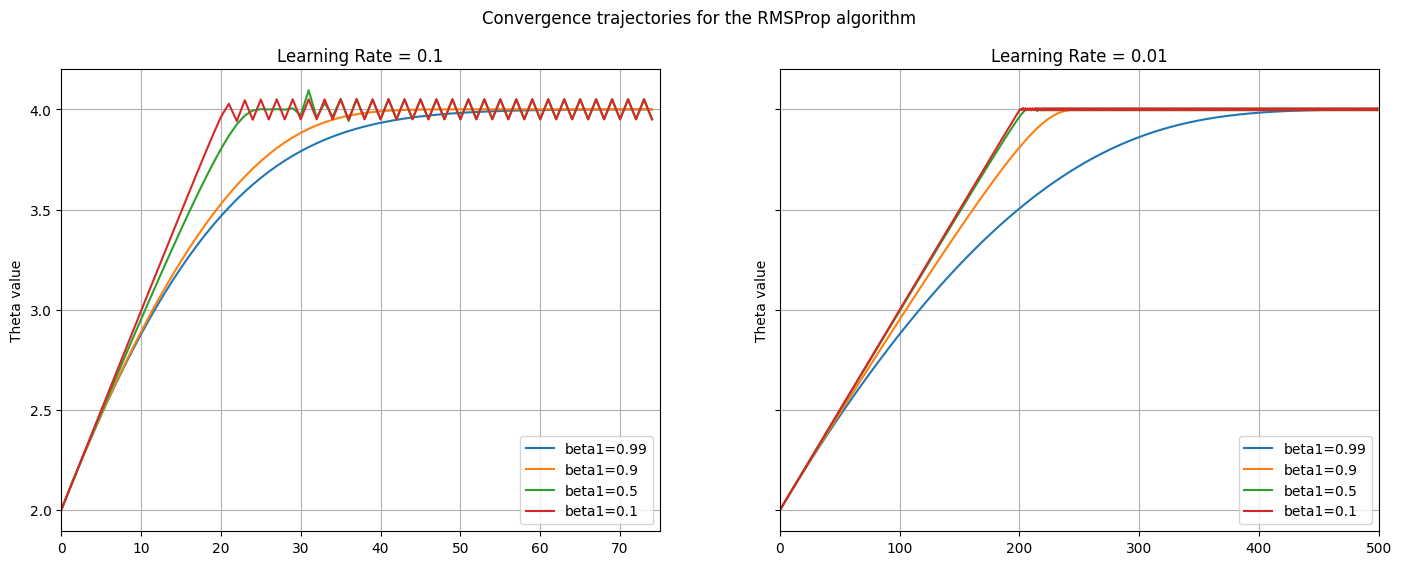

In [22]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

param_grid = {'lr': [0.1, 0.01], 'beta':[0.99, 0.9, 0.5, 0.1]}
n_learning_rates = len(param_grid['lr'])
param_list = list(ParameterGrid(param_grid))

dL = lambda y: 2 * (y - 4)

fig, axs = plt.subplots(ncols=n_learning_rates, figsize=(17, 6), sharex=False, sharey=True)   
fig.suptitle('Convergence trajectories for the RMSProp algorithm')

for i, lr in enumerate(param_grid['lr']):

    ax = axs[i] if n_learning_rates > 1 else axs
    filtered_params = [p for p in param_list if p['lr'] == lr]

    if lr == 0.1:
        epochs = 75
    elif lr == 0.01:
        epochs = 500
    else:
        epochs = 3000

    for params in filtered_params:
        theta_initial= 2.0
        
        print(f'\nRMSPropConfiguration: {params}')
        solver = RMSPropMomentum(dL=dL, lr=lr, beta=params['beta'], epochs=epochs)
        solver.solve(theta_initial=theta_initial)

        label = f"beta1={params['beta']}"
        ax.set_title(f'Learning Rate = {lr}')
        ax.plot(solver.theta_result, label=label)
        ax.set_xlim([0, epochs])
        ax.grid(True)
        ax.set_ylabel('Theta value')
        ax.legend(loc = 'lower right')

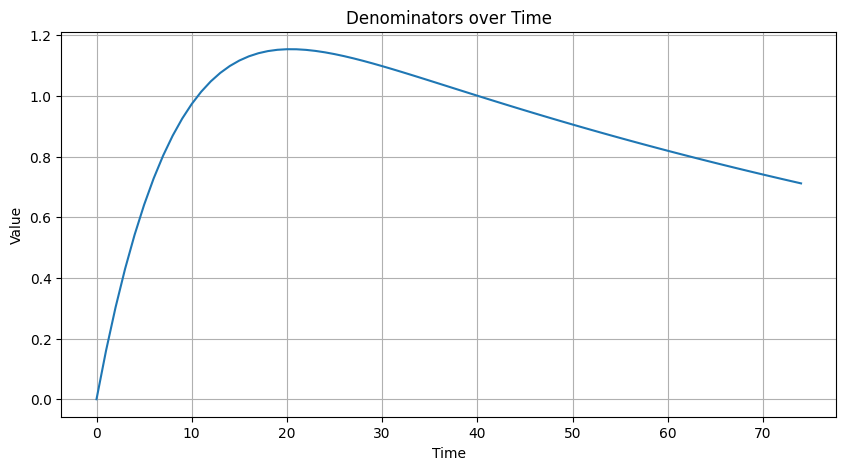

In [194]:
v = solver.v_result

def plot_values(values, title):

    plt.figure(figsize=(10, 5))
    plt.plot(values, label='Values over Time m_hat')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_values(v, 'Denominators over Time')

In [16]:
import numpy as np
from scipy.integrate import fixed_quad
from scipy.interpolate import interp1d
from concurrent.futures import ThreadPoolExecutor
from numba import njit
from typing import Callable

class NonlocalSolverMomentum:
    def __init__(self, f: Callable, dL: Callable, t_span: list, y0: np.array, beta: float,
                 alpha: float, lambda_:float = 0, verbose: bool = True):
        
        np.random.seed(33)

        self.f = f
        self.t_span = t_span
        self.y0 = y0 
        self.alpha = alpha
        self.t = np.arange(t_span[0], t_span[1], alpha)
        self.beta = beta
        self.lambda_ = lambda_

        self.k = lambda s: np.exp(-((1-beta)/ self.alpha) * s)
        self.dL = dL
        
        self.G_initial_value = 15

        self.smoothing_factor = 0.5
        self.smoothing_factor_max = 0.9999
        self.increments = np.linspace(self.smoothing_factor, self.smoothing_factor_max, num=int(1e3))
        self.max_value_index = False

        self.max_iteration = int(1e10)
        self.global_error_tolerance = 1e-4
        self.verbose = verbose


    def __initial_solution__(self) -> np.array:
        return self.__solve_ode__(self.f)
    
    def __solve_ode__(self, rhs_ode: Callable) -> np.array:
        t_values = self.t
        y_values = np.zeros(t_values.shape)
        y_values[0] = self.y0.item() if isinstance(self.y0, np.ndarray) else self.y0
        for i in range(1, len(t_values)):
            y_values[i] = y_values[i - 1] + self.alpha * rhs_ode(t_values[i - 1], y_values[i - 1])
        return y_values
    
    def __rhs_with_integral_part__(self, y: np.array) -> np.array:
        y_interpolated = interp1d(self.t, y, kind='cubic', fill_value="extrapolate", assume_sorted=True)

        self.vc = []
        def nonlocalpart(t):
            def integrand(tp):
                k_value = self.k(tp)
                df_value = self.dL(y_interpolated(t-tp))
                common_term = df_value + 0.5 * self.lambda_ * y_interpolated(tp)
                return k_value * (common_term ** 2)
            
            denominator, _ = fixed_quad(lambda tp: integrand(tp), 0, t, n=int(1e3))

            prefactor_denominador_v = (1 - self.beta) / self.alpha 
            self.vc.append((t, prefactor_denominador_v * denominator))   
            value_denominator = np.sqrt(prefactor_denominador_v * denominator + np.exp(-(1-self.beta)/self.alpha * t) * self.G_initial_value) 
            return np.array(dL(y_interpolated(t)) / value_denominator)

        def rhs(t, y):
            return self.f(t, y_interpolated(t)) - nonlocalpart(t)

        return self.__solve_ode__(rhs)
    
    @staticmethod
    @njit(parallel=True)
    def __global_error__(y_new: np.array, y_guess: np.array) -> float:
        diff = y_new - y_guess
        return np.sqrt(np.sum(diff ** 2))
    
    @staticmethod
    @njit(parallel=True)
    def __next_y__(smoothing_factor: float, y_current: np.array, y_guess: np.array) -> np.array:
        return (smoothing_factor * y_current) + ((1.0 - smoothing_factor) * y_guess)            
        
    def solve(self):
        self.iteration = 0

        y_current = self.__initial_solution__()
        y_guess = self.__rhs_with_integral_part__(y_current)
        current_error = self.__global_error__(y_current, y_guess)

        if self.verbose:
            print(f"Iteration {self.iteration} advanced. Current error: {current_error}.")

        last_error = current_error
        while current_error > self.global_error_tolerance:
            
            y_new = self.__next_y__(self.smoothing_factor, y_current, y_guess)
            y_guess = self.__rhs_with_integral_part__(y_new)
            current_error = self.__global_error__(y_new, y_guess)

            y_current = y_new
            self.iteration += 1

            if current_error > last_error:
                    if self.max_value_index:
                        print(f'Maximum value of the smoothing factor reached. The algorithm will stop without reaching the desired tolerance. The error is {current_error}.')
                        break

                    try:
                        next_factor = self.increments[np.searchsorted(self.increments, self.smoothing_factor, side='right')]
                    except IndexError:
                        next_factor = self.smoothing_factor_max
                        print(f'Smoothing factor is at maximum value.')
                        self.max_value_index = True

                    self.smoothing_factor = min(self.smoothing_factor_max, next_factor)
            last_error = current_error

            if self.verbose and self.iteration % 1 == 0:
                print(f"Iteration {self.iteration} advanced. Current error: {current_error}.")

            if self.iteration >= self.max_iteration:
                print(f"Maximum number of iterations reached. Current error: {current_error}.") 
                break
            
        print(f'Last iteration: {self.iteration}. Final error: {current_error}')

        self.y = y_guess
        self.global_error = current_error

        return self.t, self.y


Nonlocal Continuous Adam Configuration: {'beta': 0.99, 'lr': 0.1}
Iteration 0 advanced. Current error: 52.82106045797579.
Iteration 1 advanced. Current error: 24.31499195031094.
Iteration 2 advanced. Current error: 4.696879605464073.
Iteration 3 advanced. Current error: 3.489549009284949.
Iteration 4 advanced. Current error: 1.380559617850356.
Iteration 5 advanced. Current error: 0.4455825223999964.
Iteration 6 advanced. Current error: 0.3090825214812479.
Iteration 7 advanced. Current error: 0.1470825149031112.
Iteration 8 advanced. Current error: 0.05133830118765128.
Iteration 9 advanced. Current error: 0.024462863318008163.
Iteration 10 advanced. Current error: 0.015163437688382698.
Iteration 11 advanced. Current error: 0.0076171541097523115.
Iteration 12 advanced. Current error: 0.003111971167189939.
Iteration 13 advanced. Current error: 0.0012787403152354191.
Iteration 14 advanced. Current error: 0.000700600781362266.
Iteration 15 advanced. Current error: 0.00040616423210821105.
I

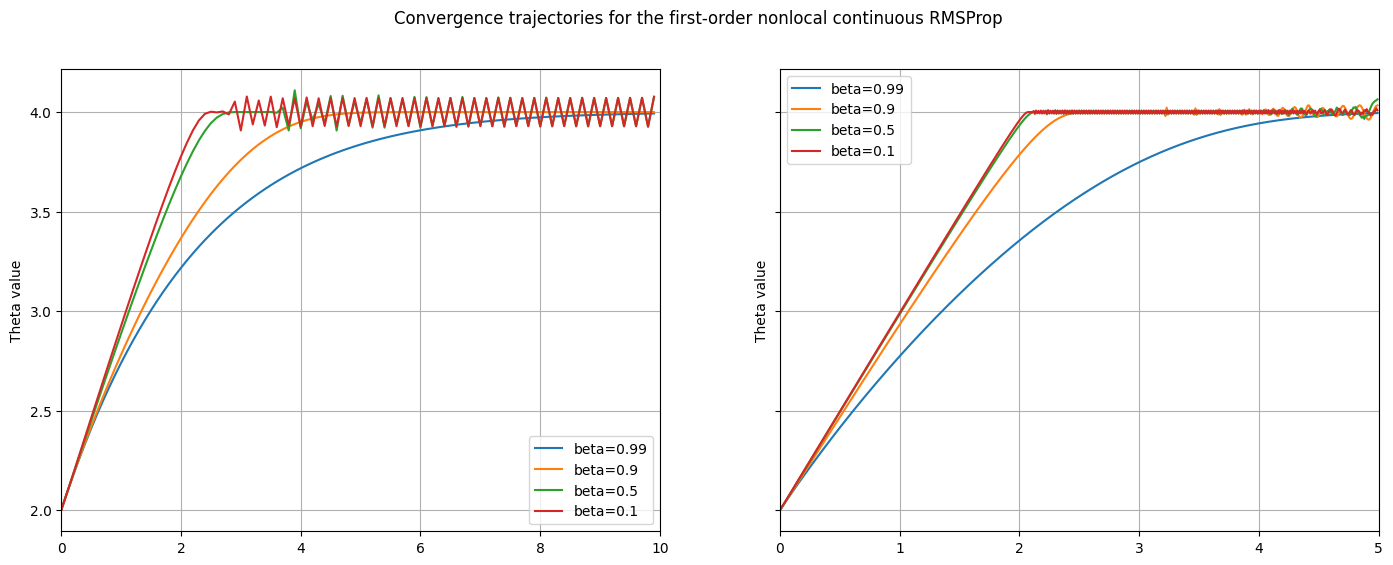

In [19]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

param_grid = {'lr': [0.1, 0.01], 'beta':[0.99, 0.9, 0.5, 0.1]}
n_learning_rates = len(param_grid['lr'])
param_list = list(ParameterGrid(param_grid))

fig, axs = plt.subplots(ncols=n_learning_rates, figsize=(17, 6), sharex=False, sharey=True)   
fig.suptitle('Convergence trajectories for the first-order nonlocal continuous RMSProp')

f = lambda x, y: 0.0
dL = lambda y: 2 * (y - 4)

for i, lr in enumerate(param_grid['lr']):

    ax = axs[i] if n_learning_rates > 1 else axs
    filtered_params = [p for p in param_list if p['lr'] == lr]

    if lr == 0.1:
        t = [1e-12, 10]
    elif lr == 0.01:
        t = [1e-12, 5]
    elif lr == 0.001:
        t = [1e-12, 50]

    for params in filtered_params:
        print(f'\nNonlocal Continuous Adam Configuration: {params}')
        solver = NonlocalSolverMomentum(f=f, dL=dL, t_span=t, y0=np.array([2.0]), alpha=params['lr'],
                                beta=params['beta'])
        t_values, y_values = solver.solve()
        
        label = f"beta={params['beta']}"
        ax.plot(t_values, y_values, label=label)
        ax.set_title(f'Learning Rate = {lr}')
        ax.set_ylabel('Theta value')
        ax.legend(loc = 'best')
        ax.grid(True)
        ax.set_xlim([t[0], t[1]])

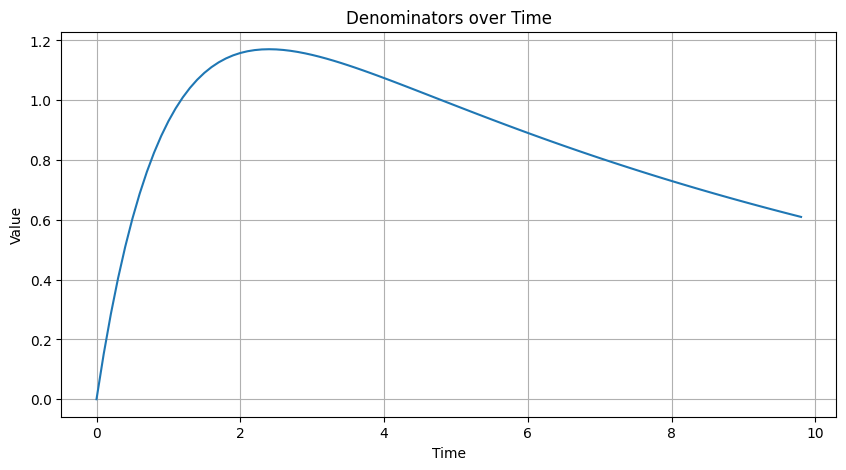

In [202]:
denominators = solver.vc

def plot_values(values, title):
    times = [item[0] for item in values]
    vals = [item[1] for item in values]

    plt.figure(figsize=(10, 5))
    plt.plot(times, vals, label='Values over Time m_hat')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_values(denominators, 'Denominators over Time')